Step 2. 데이터셋 구성하기
    
    tf.keras 안에 있는 datasets 가져와서 구성하기
    
Step 3. 생성자 모델 구현하기
    
    - (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
    
    - noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
    
    - 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.
    
Step 4. 판별자 모델 구현하기

    - (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
    
    - 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.
    
Step 5. 손실함수와 최적화 함수 구현하기

    - 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
    
    - 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
    
    - 생성자와 판별자를 최적화하는 optimizer를 정의합니다.
    
Step 6. 훈련과정 상세 기능 구현하기

    - 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
    
    - 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
    
    - 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
    
    - training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.
    
    
Step 7. 학습 과정 진행하기

    - 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
    
    - 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
    
    - 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.
    
- (참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
- 우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.

Step 8.(optional) Gan 훈련 과정 개선하기

    - STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
    
    - 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

# 1. 데이터셋 가져오기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

train_x.shape

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


- 각 픽셀을 -1, 1로 정규화시킨다
- 중앙값을 0 으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠준다

In [4]:
train_x = train_x.astype('float32')
train_x = (train_x - 127.5)/127.5

In [5]:
train_x.shape

(50000, 32, 32, 3)

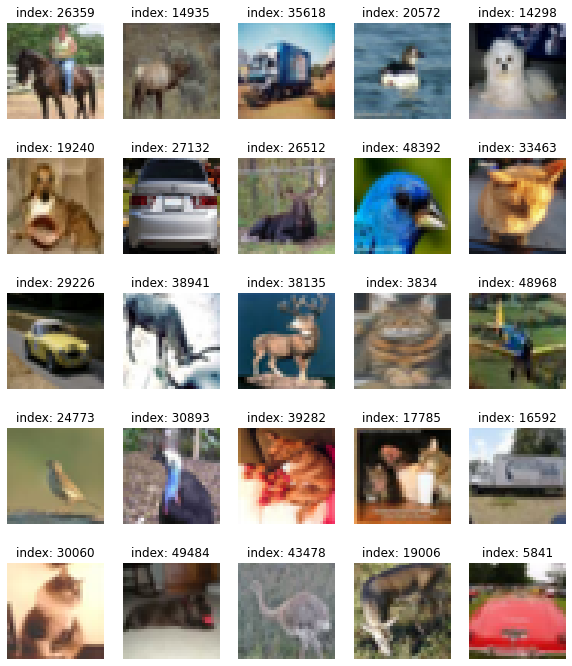

In [6]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2.0)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

In [7]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

In [8]:
BUFFER_SIZE = 50000 # 전체 데이터를 섞기 위해 6만장으로 선정한다
BATCH_SIZE = 256 # 모델이 한번에 학습할 데이터의 양

# shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것이다

BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양입니다.
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행합니다. 이러한 방식을 미니 배치 학습 이라고 합니다.

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# train_x라는 넘파이배열형 자료를 섞고, 이를 배치 사이즈에 따라 나눠준다
# 데이터가 잘 섞이게 하기 위해 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다

from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다

# 2. 생성자 모델 구현하기

# GAN (Generated Adverserial Network)

- 생성자(Generator)는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해 냅니다. 즉, 무에서 유를 창조하는 것과 같은 역할을 합니다.
    
    - 판별자(Discriminator)는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real 인지, Fake 인지에 대한 판단 정도를 실숫값으로 출력합니다.

In [10]:
def make_generator_model(): # 해당 함수를 통해 언제든 생성자를 생성할 수 있도록 해준다

    # Start
    model = tf.keras.Sequential() # 모델을 시작한 후 레이어를 차곡차곡 쌓아준다

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    #Conv2DTranspose 레이어는 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    # batchnormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화해주고
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    # 마지막 층에 tanh 활성화 함수를 적용 --> -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함
    

    # 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 
    # (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나간다
    
    
    return model

In [11]:

#생성자 모델 만들어주기
generator = make_generator_model() # make_generator_model 을 generator 라는 변수에 저장...기억할 것!

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

generator.summary()를 통해 모델의 계층이 어떠한 구주로 되어있는 지 알 수 있다.

In [12]:
noise = tf.random.normal([1, 100]) 

# tf.random.normal 을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다
# noise 란 무엇인가?
# 단순히 기존 이미지의 데이터로부터 값을 뽑아서 새로운 이미지를 생성하는 것 같다

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

(o) 생선된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인 

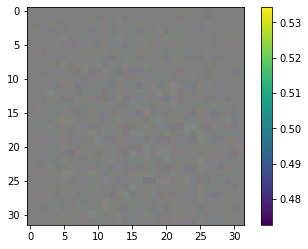

In [14]:
plt.imshow((generated_image[0]+1)/2.0)
plt.colorbar()
plt.show()

사진 채널이 3이기 때문에 그레이에서 변경해줘야 할 것 같다

# 3. 판별자 모델 구현하기

판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 한다.

In [15]:
#판별자 모델 만들어주기
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

--> 

     -Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나간다.
     -첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)까지 줄어들게 된다.

    - 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환한다. 
    - 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 한다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 된다다.

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

# 생성자로 부터 생성된 가짜 이미지를 판별자에 입력시켜보기

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00086761]], dtype=float32)>

# Step 5. 손실함수와 최적화 함수 구하기
# generator_loss, discriminator_loss

- tf.keras.losses

- 참, 거짓을 구분 짓는 이진분류를 하기 위해 binary cross entropy 사용

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # 매우 단순한 코드인 것 같다
 # 생성자는 본인이 만든 fake image 가 최대한 진짜 처럼 만들고 싶어한다
 # 즉 판별자를 속일 만큼 좋은 가짜를 만드려한다
 # 그 반대로 판별자는 fake image 를 잘 찾아내는 것이 목적이며, fake image에게 전부 0이란 값을 부여하는 것이 목적이다
 # 이러한 관계를 경찰과 도둑이라고도 한다

- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)

- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

In [19]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector) # 벡터 값을 전부 1로 변환해준다 (비교하기 위해)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

보면 기존 벡터값이 전부 1로 변환된 것을 볼 수 있다

tf.ones_like()함수 와 반대로 값을 전부 0으로 변환시켜주는 tf.zeros_like() 함수가 있다
_____________________________

generator_loss() 
____________________

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

discriminator_loss()
______________________

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

최적화 함수 (optimizor)  -  'tf.keras.optimizers'

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5) #1e-4에서 2e-4, 0.5로 변경
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

In [24]:
noise_dim = 100
num_examples_to_generate = 16 # 샘플 사진 16장 생성하기
# 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 
# 고정된 seed 노이즈를 만들어두어야 합니다.

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# Step 6. 훈련과정 설계

훈련을 위한 코드를 만들어보기

- 하나의 배치 당 진행할 train_step 만들기
- 직접 session을 열어서 학습했다가 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해주는 python decorator

In [25]:
@tf.function    # @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  
        #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  
        #(4) generated_images 생성

        
        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음

(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함

(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기

(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성

(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력

(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산

(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산

(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산

(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신

(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]): 
        plt.subplot(4, 4, i+1) 
        plt.imshow(predictions[i] * 0.5 + 0.5) 
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Step 7. 학습 과정 진행하기

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인


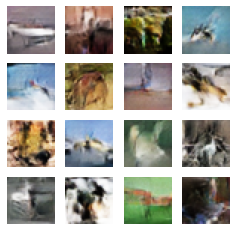

Time for training : 8612 sec


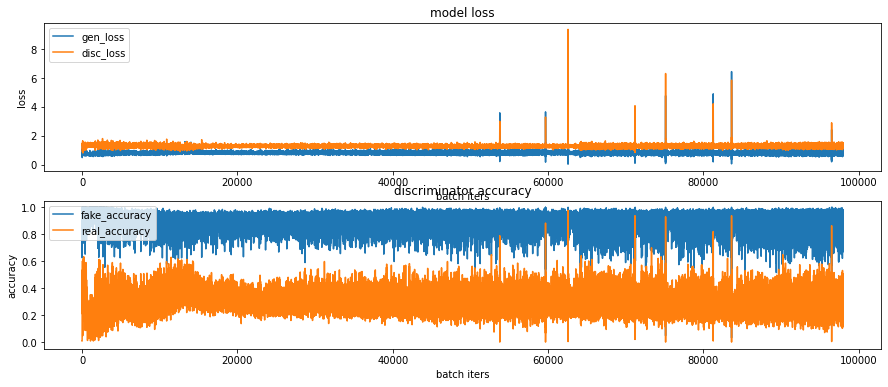

CPU times: user 2h 28min 45s, sys: 11min 2s, total: 2h 39min 48s
Wall time: 2h 23min 38s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

학습과정 시각화
________________

In [33]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1326155 Feb 15 05:21 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


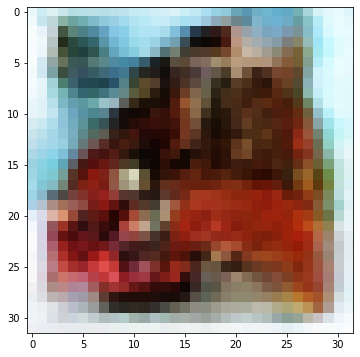

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow((generated_image[0]+1)/2.0)
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [35]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

# 회고: 

소소한 것들:
______________________
(train_x - 127.5)/127.5 로 정규화를 진행하여 값을 -1 ~ 1 사이로 맞춰주고 거기에 맞게  plt.imshow((train_x[random_index]+1)/2.0 도 맞춰주는 것을 배웠다.

생성자 모델의 마지막 레이어를 


생성자의 마지막 레이어에 있는 tanh도 sigmoid로 바꿔보려고 시도해봤다. Min-Max Normalization으로 데이터를 0 과 1 사이의 값으로 스케일링 해보고 마지막 레이어의 활성화 함수를 sigmoid로 바꿔봤지만 결국 코딩의 벽을 넘어 제대로 실현시키지 못했다. 
컨볼루션 레이어도 추가해봤으나 시간만 낭비했다. 

주위의 피드백으로 인해 DCGAN 모델은 건드리지 않기로 결정했고 결국 cifar10 픽셀값들을 reshape 해주고 지난 cs231 수업에 배웠던 adams 를 한 번 써보고 끝났다. 그래프를 보니 각 생성자 모델과 판별자 모델 값들간의 격차가 너무 큰 것 같다. 더 많은 시도를 해보고 싶은 욕심이 나지만 일단 내일 발표 준비 부터 하자.

GAN은 생각보다 재밌는 것 같다.